In [2]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt


def run_inference(img_np, model_path, input_name, confidence_threshold, iou_threshold):
    """
    Runs inference on an image using a YOLOv8 model.

    Args:
        img_np (np.ndarray): The input image in BGR format.
        model_path (str): Path to the YOLOv8 ONNX model.
        input_name (str): Name of the model's input tensor.
        confidence_threshold (float): Minimum confidence score to keep a detection.
        iou_threshold (float): IoU threshold for non-maximum suppression.

    Returns:
        list[dict]: A list of detections, each with 'label', 'score', and 'bbox'.
    """
    h, w = img_np.shape[:2]

    # Resize the image to 640x640 as expected by YOLO model
    resized = cv2.resize(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB), (640, 640))
    image_data = resized.astype(np.float32) / 255.0
    image_data = np.transpose(image_data, (2, 0, 1))[np.newaxis, :]

    # Load YOLO model
    session = ort.InferenceSession(model_path)
    outputs = session.run(None, {input_name: image_data})[0]
    outputs = np.transpose(np.squeeze(outputs))

    # Rescale coordinates to the original image size
    x_factor, y_factor = w / 640, h / 640

    boxes, scores, class_ids = [], [], []
    for det in outputs:
        x, y, bw, bh = det[:4]
        confs = det[4:]
        score = np.max(confs)
        if score >= confidence_threshold:
            class_id = int(np.argmax(confs))
            left = int((x - bw / 2) * x_factor)
            top = int((y - bh / 2) * y_factor)
            width = int(bw * x_factor)
            height = int(bh * y_factor)
            boxes.append([left, top, width, height])
            scores.append(float(score))
            class_ids.append(class_id)

    # Apply Non-Maximum Suppression
    indices = cv2.dnn.NMSBoxes(boxes, scores, confidence_threshold, iou_threshold)
    detections = []
    for i in indices.flatten():
        box = boxes[i]
        detections.append({
            "label": "signature",
            "score": scores[i],
            "bbox": [box[0], box[1], box[0] + box[2], box[1] + box[3]]
        })

    return detections


def detect_signatures_in_png(image_path: str, model_path="yolov8s.onnx", confidence_threshold=0.3, iou_threshold=0.3, output_image_path="annotated_image.png"):
    """
    Detect signatures in a PNG image and save the annotated result.
    """
    # Load the PNG image
    img_cv = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) 

    # Run signature detection
    session = ort.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name  # Assuming first input is the correct one

    detections = run_inference(img_cv, model_path, input_name, confidence_threshold, iou_threshold)

    # Draw bounding boxes around detected signatures
    original = img_cv
    for item in detections:
        color = (0, 255, 0)  
        label = f"{item['label']} ({item['score']:.2f})"
        cv2.rectangle(original, (item['bbox'][0], item['bbox'][1]), 
                      (item['bbox'][2], item['bbox'][3]), color, 2)
        cv2.putText(original, label, (item['bbox'][0], item['bbox'][1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Save the annotated image as PNG
    cv2.imwrite(output_image_path, original)
    print(f"✅ Saved: {output_image_path}")

In [3]:
image_path = "handwritten_signatures.png"  
detect_signatures_in_png(image_path)

✅ Saved: annotated_image.png


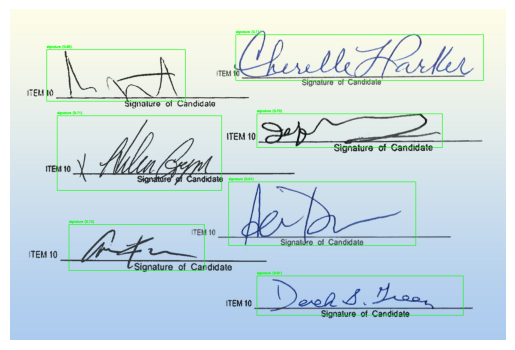

In [4]:
# Load the saved annotated image
annotated_image_path = "annotated_image.png"  # Path to the saved annotated image

# Load the image using OpenCV
annotated_image = cv2.imread(annotated_image_path)

# Convert BGR to RGB (OpenCV uses BGR by default)
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Display the image inline
plt.imshow(annotated_image_rgb)
plt.axis('off') 
plt.show()